# Algorytmy wspomagania decyzji
***
### Termin: Czwartek 11:15-13:00 TP,
### Prowadzący: Mgr inż. Cyprian Mataczyński,
### Grupa: Adrian Sobecki 248942, Mateusz Tkacz 248961
### Temat projektu: Zastosowanie algorytmu k-najbliższych sąsiadów do rozpoznawania chorób serca

***

### Cel i zakres projektu: 
#### Tematem projektu będzie zastosowanie algorytmu k-najbliższych sąsiadów do rozpoznawania chorób serca. Do tego celu wykorzystamy własną implementacją algorytmu oraz zbiór ze portalu Kaggle. Bazowo algorytm będzie wykonywał klasyfikację binarne. W późniejszym etapie rozbudujemy go o, np. klasyfikację do grup ryzyka wystąpienia choroby (np. grupa najmniejszego ryzyka, grupa niskiego ryzyka, grupa wysokiego ryzyka).

### Informacje o atrybutach


                                               
1. Age: wiek pacjenta [lata]

2. Sex: płeć pacjenta [M: Mężczyzna, F: Kobieta]

3. ChestPainType: rodzaj bólu klatki piersiowej [TA: typowy ból dławicowy, ATA: nietypowy ból dławicowy, NAP: ból niedławicowy, ASY: bezobjawowy]

4. RestingBP: spoczynkowe ciśnienie krwi [mm/Hg]

5. Cholesterol: poziom cholesterolu [mm/dl]

6. FastingBS: poziom cukru we krwi na czczo [1: jeśli > 120 mg/dl, 0: w przeciwnym razie]

7. RestingECG: wynik elektrokardiografii w spoczynku [Normal: Normalny, ST: ze zmianami odchylenia fali ST-T, LVH: prawdopodobne lub pewne wystąpienie przerostu lewej komory serca według kryteriów Estesa]

8. MaxHR: maksymalna osiągnięta częstość akcji serca [Wartość numeryczna między 60 a 202]

9. ExerciseAngina: dławica wysiłkowa [Y: Tak, N: Nie]

10. Oldpeak: zmiana odcinka ST (Obniżenie odcinka ST wywołane wysiłkiem fizycznym) [Wartość numeryczna]

11. ST_Slope: nachylenie odcinka ST w trakcie maksymalnego obciążenia [Up: nachylenie w górę, Flat: płaskie, Down: nachylenie w dół]

12. HeartDisease: klasa wyjściowa [1: choroba serca, 0: Normalny]                                        

In [11]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

df = pd.read_csv("heart.csv")
print(df.head(10))

   Age Sex ChestPainType  RestingBP  Cholesterol  FastingBS RestingECG  MaxHR  \
0   40   M           ATA        140          289          0     Normal    172   
1   49   F           NAP        160          180          0     Normal    156   
2   37   M           ATA        130          283          0         ST     98   
3   48   F           ASY        138          214          0     Normal    108   
4   54   M           NAP        150          195          0     Normal    122   
5   39   M           NAP        120          339          0     Normal    170   
6   45   F           ATA        130          237          0     Normal    170   
7   54   M           ATA        110          208          0     Normal    142   
8   37   M           ASY        140          207          0     Normal    130   
9   48   F           ATA        120          284          0     Normal    120   

  ExerciseAngina  Oldpeak ST_Slope  HeartDisease  
0              N      0.0       Up             0  
1     

## Sprawdzenie kompletności danych

In [12]:
df.isna().any()

Age               False
Sex               False
ChestPainType     False
RestingBP         False
Cholesterol       False
FastingBS         False
RestingECG        False
MaxHR             False
ExerciseAngina    False
Oldpeak           False
ST_Slope          False
HeartDisease      False
dtype: bool

<Figure size 640x480 with 0 Axes>

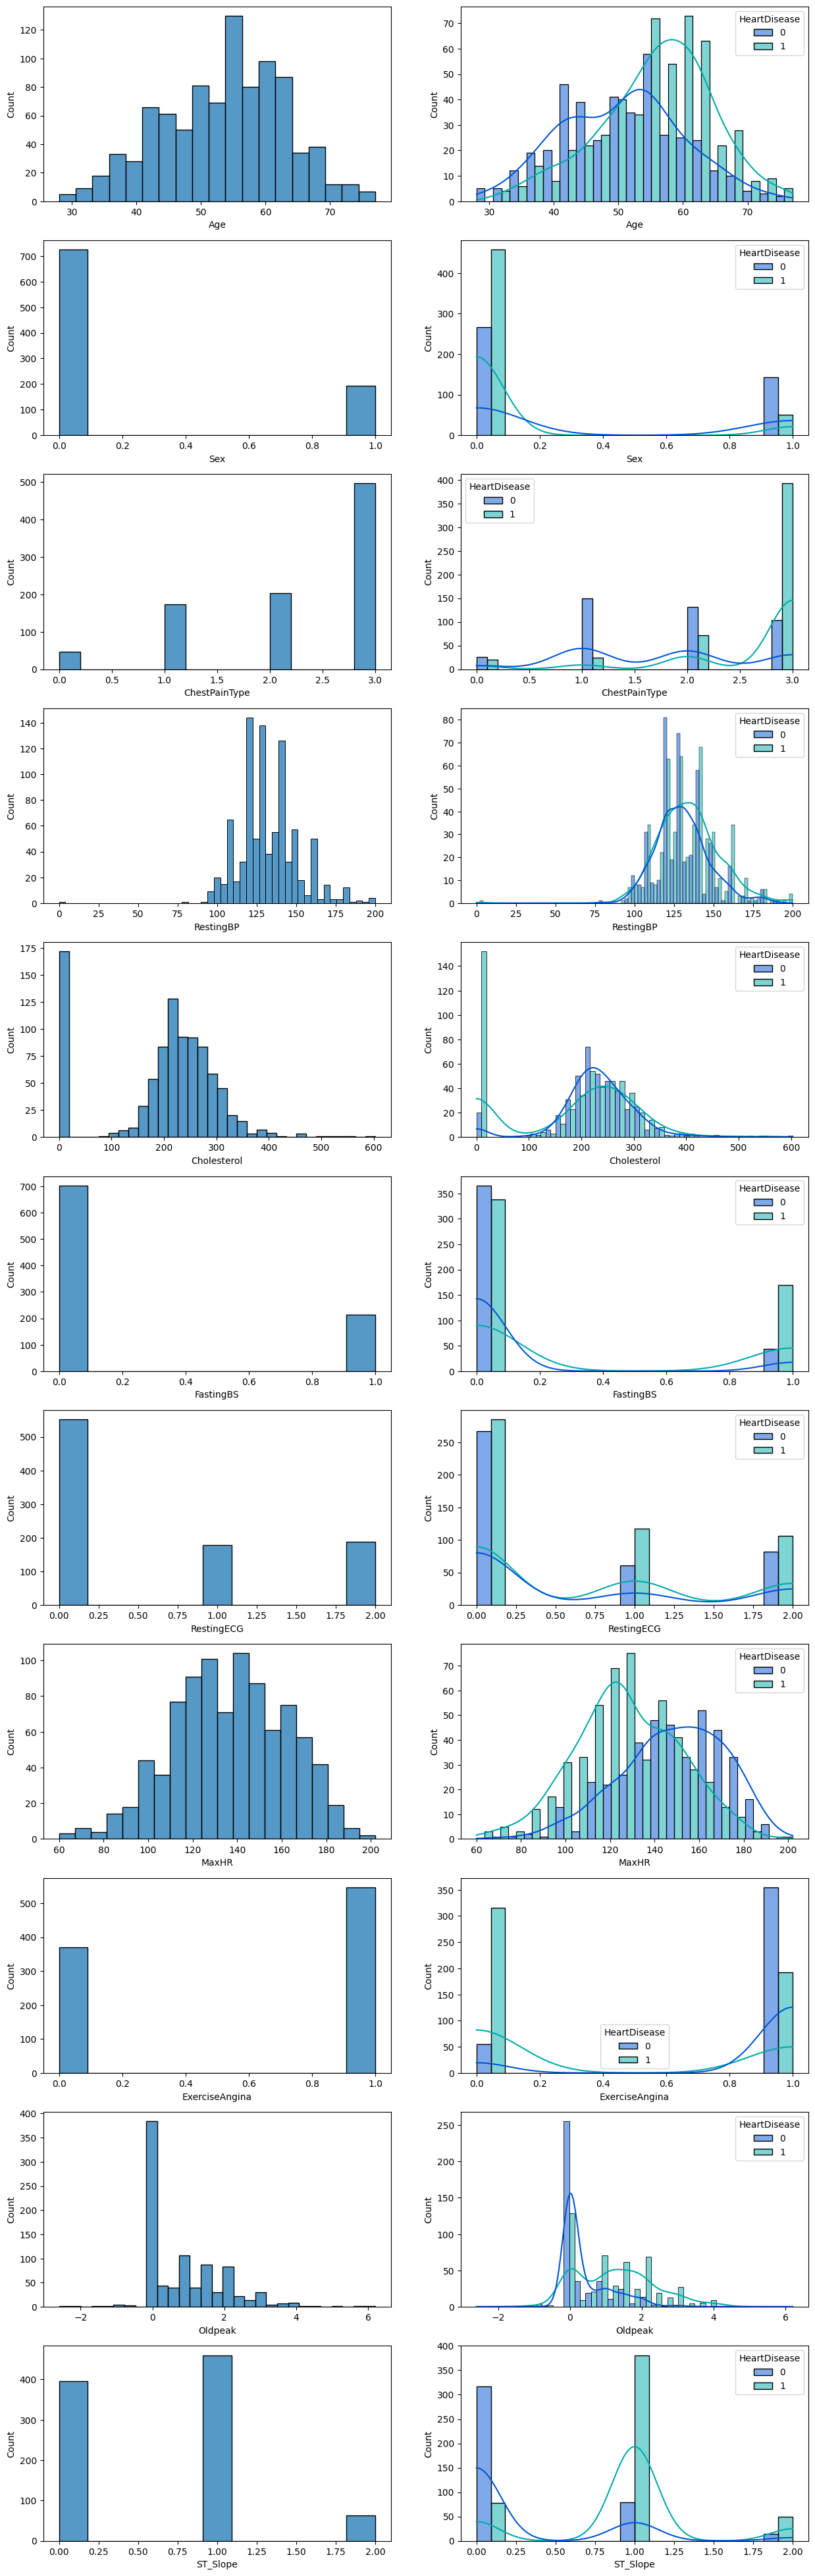

In [21]:
plt.subplots_adjust(hspace=0.4)
color = 'winter'

fig, axs = plt.subplots(11, 2, figsize=(15,50))
featureCount = 1
i=1
for feature in df.columns:
    if feature not in ["HeartDisease"] and featureCount < 14:
        plt.subplot(11,2,i)
        sns.histplot(data=df, x=feature)
        i+=1
        plt.subplot(11,2,i)
        sns.histplot(data=df, x=feature, kde=True, palette=color, hue='HeartDisease', multiple = 'dodge')
        i+=1
        featureCount+=1

In [14]:
categorical_f = ["ChestPainType", "RestingECG", "ST_Slope"]

[df[i].value_counts() for i in categorical_f]

[ASY    496
 NAP    203
 ATA    173
 TA      46
 Name: ChestPainType, dtype: int64,
 Normal    552
 LVH       188
 ST        178
 Name: RestingECG, dtype: int64,
 Flat    460
 Up      395
 Down     63
 Name: ST_Slope, dtype: int64]

In [22]:
binaries_f = ["Sex", "FastingBS", "ExerciseAngina"]

[df[i].value_counts() for i in binaries_f]

[0    725
 1    193
 Name: Sex, dtype: int64,
 0    704
 1    214
 Name: FastingBS, dtype: int64,
 1    547
 0    371
 Name: ExerciseAngina, dtype: int64]

In [23]:
df['HeartDisease'].value_counts()

1    508
0    410
Name: HeartDisease, dtype: int64

## Wnioski z analizy histogramów
- Ryzyko posiadania choroby serca rośnie wraz z wiekiem.
- Męzczyźni częściej chorują.
- Największe prawdopodobieństwo choroby serca występuję przy braku bólu klatki piersiowej.
- Spoczynkowe ciśnienie krwi zawiera niewielką ilość wartości równych 0.
- Histogram cholesterolu wygląda stosunkowo ciekawie. Można zastanowić się czy wartości 0 nie są wartościami odstającymi.
- Wysoki poziom cukru we krwi na czczo sprzyja chorobą serca.
- Występowanie dławicy wysiłkowej, duże obniżenie odcinka ST po wysiłku tym samym płaskie lub wklęsłe jego nachylenie zwiększa prawdopodobieństwo posiadania choroby serca.
- Im większa wartość pulsu maksymalnego tym mniejsza szansa na chorobę serca.

## Zamiana danych kategorycznych na numeryczne

In [16]:
df['Sex'].replace(['M', 'F'], [0, 1], inplace=True)
df['ChestPainType'].replace(['TA', 'ATA', 'NAP', 'ASY'], [0, 1, 2, 3], inplace=True)
df['RestingECG'].replace(['Normal', 'ST', 'LVH'], [0, 1, 2], inplace=True)
df['ExerciseAngina'].replace(['Y', 'N'], [0, 1], inplace=True)
df['ST_Slope'].replace(['Up', 'Flat', 'Down'], [0, 1, 2], inplace=True)


In [17]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 918 entries, 0 to 917
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Age             918 non-null    int64  
 1   Sex             918 non-null    int64  
 2   ChestPainType   918 non-null    int64  
 3   RestingBP       918 non-null    int64  
 4   Cholesterol     918 non-null    int64  
 5   FastingBS       918 non-null    int64  
 6   RestingECG      918 non-null    int64  
 7   MaxHR           918 non-null    int64  
 8   ExerciseAngina  918 non-null    int64  
 9   Oldpeak         918 non-null    float64
 10  ST_Slope        918 non-null    int64  
 11  HeartDisease    918 non-null    int64  
dtypes: float64(1), int64(11)
memory usage: 86.2 KB


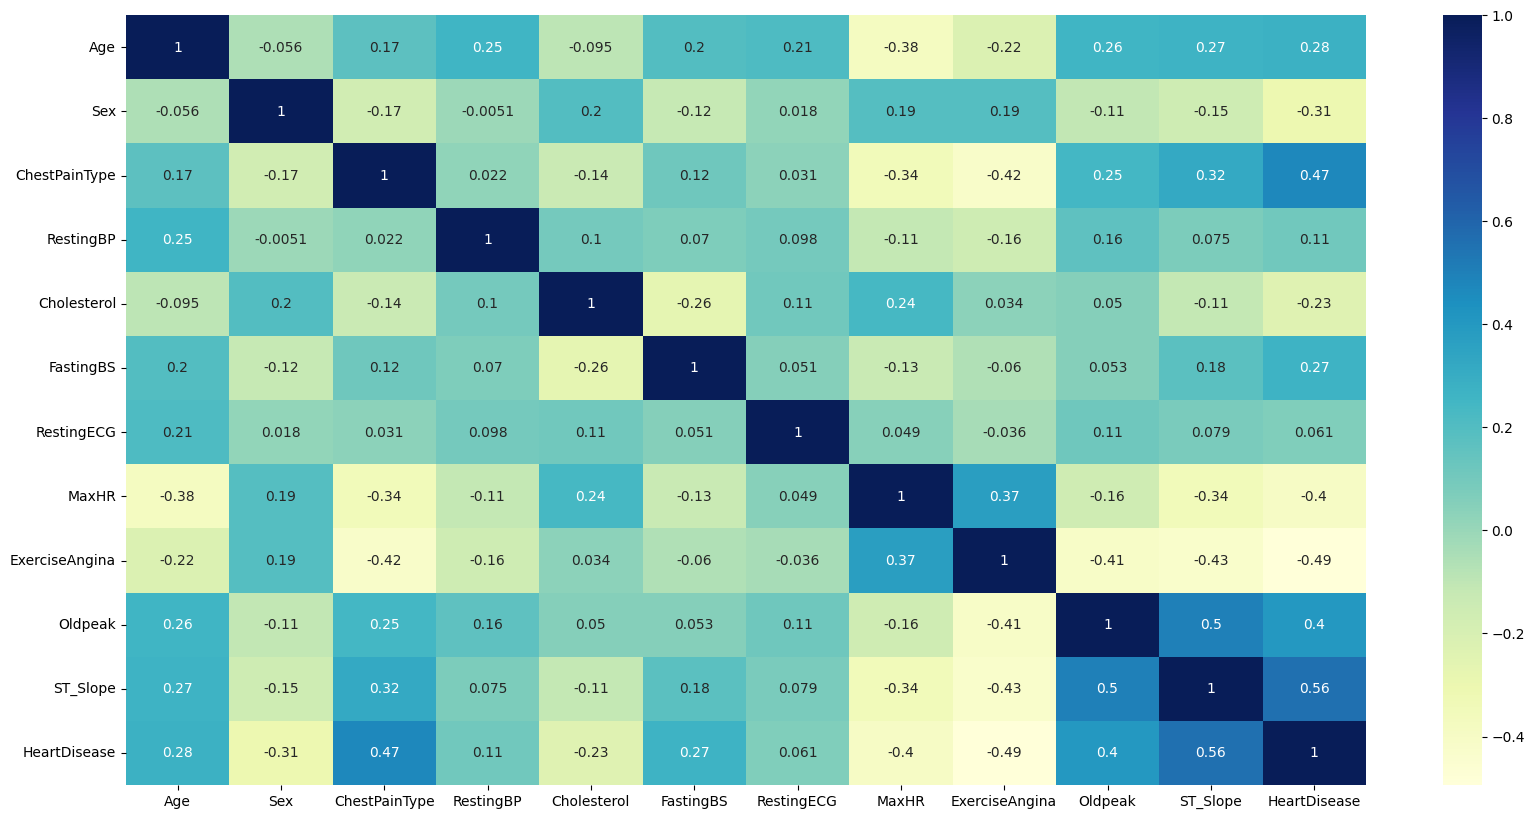

In [18]:
plt.figure(figsize=(20,10)) 
sns.heatmap(df.corr(), cmap="YlGnBu", annot=True);